In [1]:
try:
    import google.colab
    USE_COLAB = True
except:
    USE_COLAB = False
print("Use colab - ", USE_COLAB)

Use colab -  True


In [2]:
if USE_COLAB:
    !pip install --user deeppavlov

# Assignment 2. Language modeling.

This task is devoted to language modeling. Its goal is to write in PyTorch an RNN-based language model. Since word-based language modeling requires long training and is memory-consuming due to large vocabulary, we start with character-based language modeling. We are going to train the model to generate words as sequence of characters. During training we teach it to predict characters of the words in the training set.



## Task 1. Character-based language modeling: data preparation (15 points).

We train the language models on the materials of **Sigmorphon 2018 Shared Task**. First, download the Russian datasets.

In [3]:
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

--2020-04-01 12:50:46--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 533309 (521K) [text/plain]
Saving to: ‘russian-train-high.1’

russian-train-high. 100%[===================>] 520.81K  --.-KB/s    in 0.04s   

2020-04-01 12:50:46 (14.3 MB/s) - ‘russian-train-high.1’ saved [533309/533309]

--2020-04-01 12:50:48--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [0]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

from deeppavlov.core.data.simple_vocab import SimpleVocabulary

import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torch.nn as nn

import numpy as np

**1.1 (1 points)**
All the files contain tab-separated triples ```<lemma>-<form>-<tags>```, where ```<form>``` may contain spaces (*будете соответствовать*). Write a function that loads a list of all word forms, that do not contain spaces.  

In [0]:
def read_infile(infile):
    forms = []
    with open(infile, 'r') as f:
        for line in f:
            lemma, form, tags = line.split('\t')
            if ' ' in form.strip():
                continue
            forms.append(form.lower())
    return forms

In [6]:
train_words = read_infile("russian-train-high")
dev_words = read_infile("russian-dev")
test_words = read_infile("russian-test")
print(len(train_words), len(dev_words), len(test_words))
print(*train_words[:10])

9213 917 922
валлонскому незаконченным истрёпывав личного серьгам необоснованным тюти заросла идеальна гулкой


**1.2 (2 points)** Write a **Vocabulary** class that allows to transform symbols into their indexes. The class should have the method ```__call__``` that applies this transformation to sequences of symbols and batches of sequences as well. You can also use [SimpleVocabulary](https://github.com/deepmipt/DeepPavlov/blob/c10b079b972493220c82a643d47d718d5358c7f4/deeppavlov/core/data/simple_vocab.py#L31) from DeepPavlov. Fit an instance of this class on the training data.

In [7]:
vocab = SimpleVocabulary(special_tokens=["BEGIN", "END", "PAD"], save_path='.')
vocab.fit([list(x) for x in train_words])
print(len(vocab))

2020-04-01 12:50:54.273 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 49: No load path is set for SimpleVocabulary in 'infer' mode. Using save path instead


37


In [8]:
vocab(['BEGIN', 'END', 'PAD'])

[0, 1, 2]

**1.3 (2 points)** Write a **Dataset** class, which should be inherited from ```torch.utils.data.Dataset```. It should take a list of words and the ```vocab``` as initialization arguments.

In [0]:
class Dataset(TorchDataset):
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __getitem__(self, index):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.        
        """
        source = ["BEGIN", *self.data[index]]
        target = [*self.data[index], "END"]

        source_transformed = self.vocab(source)
        target_transformed = self.vocab(target)

        return torch.tensor(source_transformed), torch.tensor(target_transformed)


    def __len__(self):
        return len(self.data)

In [0]:
train_dataset = Dataset(train_words, vocab)
dev_dataset = Dataset(dev_words, vocab)
test_dataset = Dataset(test_words, vocab)

In [11]:
train_dataset[0]

(tensor([ 0, 11,  4, 12, 12,  3,  7,  9, 14,  3, 13, 16]),
 tensor([11,  4, 12, 12,  3,  7,  9, 14,  3, 13, 16,  1]))

**1.4 (3 points)** Use a standard ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with ```batch_size=1```.

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=1)
for i, (source, target) in enumerate(train_dataloader):
    if i == 10:
        break

    print(f'Butch number {i}:')
    print(source, target, sep='\n')

Butch number 0:
tensor([[ 0, 11,  4, 12, 12,  3,  7,  9, 14,  3, 13, 16]])
tensor([[11,  4, 12, 12,  3,  7,  9, 14,  3, 13, 16,  1]])
Butch number 1:
tensor([[ 0,  7,  5, 22,  4, 14,  3,  7, 25,  5,  7,  7, 17, 13]])
tensor([[ 7,  5, 22,  4, 14,  3,  7, 25,  5,  7,  7, 17, 13,  1]])
Butch number 2:
tensor([[ 0,  6,  9, 10,  8, 33, 15, 17, 11,  4, 11]])
tensor([[ 6,  9, 10,  8, 33, 15, 17, 11,  4, 11,  1]])
Butch number 3:
tensor([[ 0, 12,  6, 25,  7,  3, 20,  3]])
tensor([[12,  6, 25,  7,  3, 20,  3,  1]])
Butch number 4:
tensor([[ 0,  9,  5,  8, 23, 20,  4, 13]])
tensor([[ 9,  5,  8, 23, 20,  4, 13,  1]])
Butch number 5:
tensor([[ 0,  7,  5,  3, 24,  3,  9,  7,  3, 11,  4,  7,  7, 17, 13]])
tensor([[ 7,  5,  3, 24,  3,  9,  7,  3, 11,  4,  7,  7, 17, 13,  1]])
Butch number 6:
tensor([[ 0, 10, 28, 10,  6]])
tensor([[10, 28, 10,  6,  1]])
Butch number 7:
tensor([[ 0, 22,  4,  8,  3,  9, 12,  4]])
tensor([[22,  4,  8,  3,  9, 12,  4,  1]])
Butch number 8:
tensor([[ 0,  6, 18,  5,  4, 12,

**(1.5) 1 point** Explain, why this does not work with larger batch size.

Это происходит из-за того, что слова могут иметь разную длина, а тенсзоры поддерживают только равные длины по всем осям

**(1.6) 5 points** Write a function **collate** that allows you to deal with batches of greater size. See [discussion](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8) for an example. Implement your function as a class ```__call__``` method to make it more flexible.

In [0]:
def pad_tensor(vec, length, dim, pad_symbol):
    """
    Pads a vector ``vec`` up to length ``length`` along axis ``dim`` with pad symbol ``pad_symbol``.
    """
    pad_shape = list(vec.shape)
    pad_shape[dim] = length - pad_shape[dim]
    pad_vec = torch.zeros(pad_shape, dtype=vec.dtype) + pad_symbol
    return torch.cat([vec, pad_vec], dim=dim)

class Padder:
    def __init__(self, dim=0, pad_symbol=0):
        self.dim = dim
        self.pad_symbol = pad_symbol
    
    def __call__(self, batch):
        max_len = -1
        for single_batch in batch:
            for row in single_batch:
                max_len = max(max_len, row.shape[self.dim])
        
        batches = [[] for _ in range(len(batch[0]))]
        for single_batch in batch:
            for i, row in enumerate(single_batch):
                batches[i].append(pad_tensor(row, max_len, self.dim, self.pad_symbol))

        for i in range(len(batches)):
            batches[i] = torch.stack(batches[i])
        return batches

In [14]:
pad_tensor(torch.tensor([1, 2, 3]), 5, 0, 0)

tensor([1, 2, 3, 0, 0])

**(1.7) 1 points** Again, use ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with the batch size you like.

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=2, collate_fn=Padder(pad_symbol=vocab('PAD')))
for i, (source, target) in enumerate(train_dataloader):
    if i == 10:
        break

    print(f'Butch number {i}:')
    print(source, target, sep='\n')

Butch number 0:
tensor([[ 0, 11,  4, 12, 12,  3,  7,  9, 14,  3, 13, 16,  2,  2],
        [ 0,  7,  5, 22,  4, 14,  3,  7, 25,  5,  7,  7, 17, 13]])
tensor([[11,  4, 12, 12,  3,  7,  9, 14,  3, 13, 16,  1,  2,  2],
        [ 7,  5, 22,  4, 14,  3,  7, 25,  5,  7,  7, 17, 13,  1]])
Butch number 1:
tensor([[ 0,  6,  9, 10,  8, 33, 15, 17, 11,  4, 11],
        [ 0, 12,  6, 25,  7,  3, 20,  3,  2,  2,  2]])
tensor([[ 6,  9, 10,  8, 33, 15, 17, 11,  4, 11,  1],
        [12,  6, 25,  7,  3, 20,  3,  1,  2,  2,  2]])
Butch number 2:
tensor([[ 0,  9,  5,  8, 23, 20,  4, 13,  2,  2,  2,  2,  2,  2,  2],
        [ 0,  7,  5,  3, 24,  3,  9,  7,  3, 11,  4,  7,  7, 17, 13]])
tensor([[ 9,  5,  8, 23, 20,  4, 13,  1,  2,  2,  2,  2,  2,  2,  2],
        [ 7,  5,  3, 24,  3,  9,  7,  3, 11,  4,  7,  7, 17, 13,  1]])
Butch number 3:
tensor([[ 0, 10, 28, 10,  6,  2,  2,  2],
        [ 0, 22,  4,  8,  3,  9, 12,  4]])
tensor([[10, 28, 10,  6,  1,  2,  2,  2],
        [22,  4,  8,  3,  9, 12,  4,  1]])


## Task 2. Character-based language modeling. (35 points)

**2.1 (5 points)** Write a network that performs language modeling. It should include three layers:
1. **Embedding** layer that transforms input symbols into vectors.
2. An **RNN** layer that outputs a sequence of hidden states (you may use https://pytorch.org/docs/stable/nn.html#gru).
3. A **Linear** layer with ``softmax`` activation that produces the output distribution for each symbol.

In [0]:
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embeddings_dim, hidden_size):
        super(RNNLM, self).__init__()
        self.embeddings_dim = embeddings_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.emb = nn.Embedding(vocab_size, embeddings_dim)
        self.rnn = nn.GRU(embeddings_dim, hidden_size, batch_first=True)
        self.lin = nn.Linear(hidden_size, vocab_size)

        nn.init.kaiming_normal_(self.lin.weight)

        
    def forward(self, inputs, hidden=None):
        if hidden is None:
            hidden = torch.zeros(1, inputs.shape[0], self.embeddings_dim)

        inputs = self.emb(inputs)
        inputs, h = self.rnn(inputs)
        inputs = self.lin(inputs)
        return inputs, h

**2.2 (1 points)** Write a function ``validate_on_batch`` that takes as input a model, a batch of inputs and a batch of outputs, and the loss criterion, and outputs the loss tensor for the whole batch. This loss should not be normalized.

In [0]:
def validate_on_batch(model, criterion, x, y):
    y_dist = model(x)[0]
    y_dist = y_dist.view(-1, y_dist.shape[-1])
    y = y.view(-1)
    
    non_pad_mask = y != vocab("PAD")
    sum_loss = torch.sum(criterion(y_dist, y)[non_pad_mask])
    non_pad = torch.sum(non_pad_mask).type(torch.FloatTensor)
    return sum_loss, non_pad

**Test** 

In [18]:
test_criterion = nn.CrossEntropyLoss(reduction='none')
test_model = RNNLM(
    vocab_size=len(vocab),
    embeddings_dim=64,
    hidden_size=64
)

test_x = [[0, 4, 5, 2, 2], [0, 7, 4, 2, 2], [0, 4, 3, 3, 2], [0, 4, 5, 2, 2], [0, 7, 4, 2, 2], [0, 4, 3, 3, 2]]
test_y = [[4, 5, 1, 2, 2], [7, 4, 1, 2, 2], [4, 3, 3, 1, 2], [4, 5, 1, 2, 2], [7, 4, 1, 2, 2], [4, 3, 3, 1, 2]]

test_loss_sum1, test_non_pad1 = validate_on_batch(test_model, test_criterion, torch.tensor(test_x), torch.tensor(test_y))

test_loss_sum2, test_non_pad2 = 0, 0
for x, y in zip(test_x, test_y):
    loss_sum, pad = validate_on_batch(test_model, test_criterion, torch.tensor(x).view(1, -1), torch.tensor(y).view(1, -1))
    test_loss_sum2 += loss_sum
    test_non_pad2 += pad

print(test_loss_sum1, test_non_pad1)
print('-'*20)
print(test_loss_sum2, test_non_pad2)

tensor(75.6159, grad_fn=<SumBackward0>) tensor(20.)
--------------------
tensor(75.6159, grad_fn=<AddBackward0>) tensor(20.)


**2.3 (1 points)** Write a function ``train_on_batch`` that accepts all the arguments of ``validate_on_batch`` and also an optimizer, calculates loss and makes a single step of gradient optimization. This function should call ``validate_on_batch`` inside.

In [0]:
def train_on_batch(model, criterion, x, y, optimizer):
    model.train()
    optimizer.zero_grad()
    sum_loss, non_pad = validate_on_batch(model, criterion, x, y)
    loss = sum_loss / non_pad.detach()
    loss.backward()
    optimizer.step()
    return loss

**2.4 (3 points)** Write a training loop. You should define your ``RNNLM`` model, the criterion, the optimizer and the hyperparameters (number of epochs and batch size). Then train the model for a required number of epochs. On each epoch evaluate the average training loss and the average loss on the validation set. 

**2.5 (3 points)** Do not forget to average your loss over only non-padding symbols, otherwise it will be too optimistic.

In [0]:
def evaluate(model, criterion, dataloader, device):
    model.eval()
    loss = 0
    cnt = 0
    for source, target in dataloader:
        sum_loss, non_pad = validate_on_batch(model, criterion, source.to(device), target.to(device))
        loss += sum_loss
        cnt += non_pad
    return (loss / cnt).cpu().detach().numpy()

**Test**

In [0]:
test_criterion = nn.CrossEntropyLoss(reduction='none')
test_model = RNNLM(
    vocab_size=len(vocab),
    embeddings_dim=64,
    hidden_size=64
)

In [22]:
test_dataloader2 = DataLoader(
    dev_dataset,
    batch_size=2,
    collate_fn=Padder(dim=0, pad_symbol=vocab("PAD"))
)
test_dataloader20 = DataLoader(
    dev_dataset,
    batch_size=20,
    collate_fn=Padder(dim=0, pad_symbol=vocab("PAD"))
)
test_device = torch.device('cpu')

print(evaluate(test_model, test_criterion, test_dataloader2, test_device))
print(evaluate(test_model, test_criterion, test_dataloader20, test_device))

3.657376
3.6573749


In [0]:
USE_CUDA = True
TOTAL_EPOCH = 10
LAST_EPOCH = 0
BATCH_SIZE = 16

In [24]:
if USE_CUDA and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("device: ", device)

device:  cuda


In [0]:
model = RNNLM(
    vocab_size=len(vocab),
    embeddings_dim=16,
    hidden_size=32
).to(device)

criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=Padder(dim=0, pad_symbol=vocab("PAD"))
)
val_dataloader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=Padder(dim=0, pad_symbol=vocab("PAD"))
)

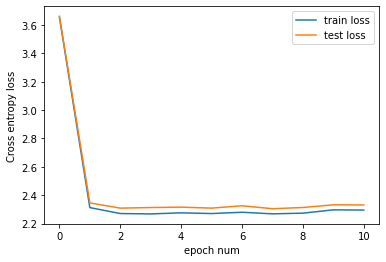

100%|██████████| 10/10 [00:38<00:00,  3.88s/it]

CPU times: user 39.1 s, sys: 861 ms, total: 39.9 s
Wall time: 40.2 s


In [26]:
%%time
train_loss = [evaluate(model, criterion, train_dataloader, device)]
validate_loss = [evaluate(model, criterion, val_dataloader, device)]

for i in trange(LAST_EPOCH, TOTAL_EPOCH):
    for x, y in train_dataloader:
        train_on_batch(model, criterion, x.to(device), y.to(device), optimizer)
    

    train_loss += [evaluate(model, criterion, train_dataloader, device)]
    validate_loss += [evaluate(model, criterion, val_dataloader, device)]

    clear_output(True)
    plt.figure('Average loss on train/validation datasets')
    plt.xlabel('epoch num')
    plt.ylabel('Cross entropy loss')
    plt.plot(train_loss, label='train loss')
    plt.plot(validate_loss, label='test loss')
    plt.legend()
    plt.show()

**2.6 (5 points)** Write a function **predict_on_batch** that outputs letter probabilities of all words in the batch.

In [50]:
model.cpu()

RNNLM(
  (emb): Embedding(37, 16)
  (rnn): GRU(16, 32, batch_first=True)
  (lin): Linear(in_features=32, out_features=37, bias=True)
)

In [0]:
def predict_on_batch(model, batch):
    model.eval()
    y_pred = nn.Softmax(dim=-1)(model(batch)[0])
    return y_pred

def predict_next_index(model, index_seq):
    index_seq = torch.tensor(index_seq).view(1, -1)
    probas = predict_on_batch(model, index_seq)[0][-1]
    idx = torch.multinomial(probas, 1)
    return int(idx.detach().numpy())

In [136]:
predict_next_index(model, [0, 29])

5

**2.7 (1 points)** Calculate the letter probabilities for all words in the test dataset. Print them for 20 last words. Do not forget to disable shuffling in the ``DataLoader``.

**2.8 (5 points)** Write a function that generates a single word (sequence of indexes) given the model. Do not forget about the hidden state! Be careful about start and end symbol indexes. Use ``torch.multinomial`` for sampling.

In [0]:
def generate(model, max_length=20, start_index=0, end_index=1):
    curr_sec = [start_index]
    while len(curr_sec) < 20:
        new_symbol = predict_next_index(model, curr_sec)
        curr_sec.append(new_symbol)
        if new_symbol == end_index:
            break
    if curr_sec[-1] != end_index:
        curr_sec.append(end_index)
    return curr_sec

In [138]:
generate(model)

[0, 4, 11, 3, 22, 15, 3, 8, 20, 6, 1]

**2.9 (1 points)** Use ``generate`` to sample 20 pseudowords. Do not forget to transform indexes to letters.

In [139]:
for i in range(20):
    idx_seq = generate(model, max_length=12, start_index=vocab('BEGIN'), end_index=vocab('END'))
    symb_seq = vocab(idx_seq)
    print(''.join(symb_seq[1:-1]))

потищо
срамочниям
дукленная
словонтанов
скростиварем
трою
сумуя
призлойшивавший
спичитами
дорросстойу
трыловуниям
ниторивавной
развурчать
повкианные
иправ
влиспоразввая
боянтрими
ниместых
торовали
эистные


**(2.10) 5 points** Write a batched version of the generation function. You should sample the following symbol only for the words that are not finished yet, so apply a boolean mask to trace active words.

In [0]:
def generate_batch(model, batch_size, max_length = 20, start_index=0, end_index=1):
    generated = []
    for i in range(batch_size):
        generated.append(generate(model, max_length=max_length, start_index=start_index, end_index=end_index)[1:-1])
    return generated

In [150]:
generated = []
for _ in range(2):
    generated += generate_batch(model, batch_size=10)

transformed = vocab(generated)
for elem in transformed:
    print("".join(elem))

струкратску
несижали
закма
тертзные
токенлуном
цикиравшимами
тистивами
вшное
злахноеной
нившива
ацтваваци
сврог
аттлеотиошное
тнолмись
хяразацироваваюшим
кови
ырпатами
снероцивной
соедаснить
тещайну


**(2.11) 5 points** Experiment with the type of RNN, number of layers, units and/or dropout to improve the perplexity of the model.